In [357]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
from xgboost import XGBClassifier
from ta import add_all_ta_features
from sklearn.feature_selection import RFE

In [358]:
WINDOW = 16 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'AAPL'      # Symbol of the desired stock

# one day 16 rows of data

In [359]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-05-12 04:00:00-04:00,78.802500,78.802500,78.560000,78.575000,78.575000,0
2020-05-12 05:00:00-04:00,78.650000,78.675000,78.502500,78.502500,78.502500,0
2020-05-12 06:00:00-04:00,78.600000,78.822500,78.535000,78.822500,78.822500,0
2020-05-12 07:00:00-04:00,78.887500,79.340000,78.887500,79.277500,79.277500,0
2020-05-12 08:00:00-04:00,79.300000,79.497500,79.000000,79.400000,79.400000,0
...,...,...,...,...,...,...
2021-05-11 13:30:00-04:00,125.776398,126.269997,125.510101,126.220100,126.220100,10206779
2021-05-11 14:30:00-04:00,126.220001,126.220001,125.540001,125.964996,125.964996,9989427
2021-05-11 15:30:00-04:00,125.973503,126.110001,125.279999,125.849998,125.849998,9604428


In [360]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)
important_columns = ['open', 'high', 'low','close','volume']

In [361]:

def calculate_diffs(diff_number, col_name):
    new_col_name = f'{col_name}_{diff_number}'
    data[new_col_name] = data[col_name].diff(diff_number)

In [362]:
# for name in important_columns:
#     for i in range(1, 11):
#         calculate_diffs(i, name)
#
# data.head(10)

In [363]:
data = data.dropna()

<AxesSubplot:xlabel='Datetime'>

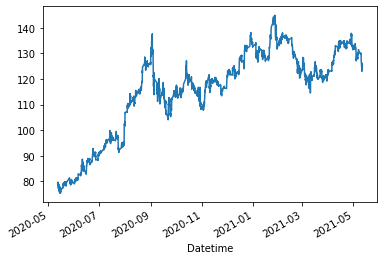

In [364]:
data['close'].plot()

In [365]:
data['close_pct'] = data['close'].pct_change()
data.head()

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2020-05-12 04:00:00-04:00,78.8025,78.8025,78.5600,78.5750,78.5750,0,NaN
2020-05-12 05:00:00-04:00,78.6500,78.6750,78.5025,78.5025,78.5025,0,-0.000923
2020-05-12 06:00:00-04:00,78.6000,78.8225,78.5350,78.8225,78.8225,0,0.004076
2020-05-12 07:00:00-04:00,78.8875,79.3400,78.8875,79.2775,79.2775,0,0.005772
2020-05-12 08:00:00-04:00,79.3000,79.4975,79.0000,79.4000,79.4000,0,0.001545


In [366]:
data.describe()

,open,high,low,close,Adj Close,volume,close_pct
count,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4.185000e+03,4184.000000
mean,115.308320,115.852400,114.665089,115.306129,115.306129,5.069890e+06,0.000127
std,16.960806,17.796684,16.909362,16.949607,16.949607,8.579219e+06,0.005417
min,75.087502,75.537500,58.360000,75.300000,75.300000,0.000000e+00,-0.051319
25%,109.000000,109.463753,108.290000,108.980000,108.980000,0.000000e+00,-0.001888
50%,119.520000,120.000000,118.700000,119.470000,119.470000,0.000000e+00,0.000097
75%,128.280000,128.705002,127.592400,128.270004,128.270004,8.290396e+06,0.002274
max,144.900000,438.440000,144.590000,144.910000,144.910000,9.845401e+07,0.051457


In [367]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    data = add_all_ta_features(
        data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    # for i in range(1,50):
    #     data[f'close{i}'] = data['close'].shift(i)
    # Remove columns that won't be used as features
    # del (data['Adj Close'])

    return data


In [368]:
data

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2020-05-12 04:00:00-04:00,78.802500,78.802500,78.560000,78.575000,78.575000,0,NaN
2020-05-12 05:00:00-04:00,78.650000,78.675000,78.502500,78.502500,78.502500,0,-0.000923
2020-05-12 06:00:00-04:00,78.600000,78.822500,78.535000,78.822500,78.822500,0,0.004076
2020-05-12 07:00:00-04:00,78.887500,79.340000,78.887500,79.277500,79.277500,0,0.005772
2020-05-12 08:00:00-04:00,79.300000,79.497500,79.000000,79.400000,79.400000,0,0.001545
...,...,...,...,...,...,...,...
2021-05-11 13:30:00-04:00,125.776398,126.269997,125.510101,126.220100,126.220100,10206779,0.003500
2021-05-11 14:30:00-04:00,126.220001,126.220001,125.540001,125.964996,125.964996,9989427,-0.002021
2021-05-11 15:30:00-04:00,125.973503,126.110001,125.279999,125.849998,125.849998,9604428,-0.000913


In [369]:
data.columns

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', 'close_pct'], dtype='object')

In [370]:
def create_class_column(row, lowest_threshold, higher_threshold):
    if row['close_shift'] - row['close'] > higher_threshold:
        return 1
    if row['close_shift'] - row['close'] < lowest_threshold:
        return -1
    else:
        return 0

In [371]:
data = _get_indicator_data(data)
data['close_shift'] = data.shift(-WINDOW)['close']
data

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-12 04:00:00-04:00,78.802500,78.802500,78.560000,78.575000,78.575000,0,NaN,-0.000000e+00,0,0.000000,...,0.000000,78.575000,0.000000,0.000000,0.000000,0.000000,-31.855314,0.000000,0.000000,77.2500
2020-05-12 05:00:00-04:00,78.650000,78.675000,78.502500,78.502500,78.502500,0,-0.000923,-0.000000e+00,0,0.000000,...,0.000000,78.545317,0.000000,0.000000,0.000000,0.000000,-0.092269,-0.092311,-0.092269,77.9750
2020-05-12 06:00:00-04:00,78.600000,78.822500,78.535000,78.822500,78.822500,0,0.004076,0.000000e+00,0,0.000000,...,0.000000,78.663281,0.000000,0.000000,0.000000,0.000000,0.407630,0.406802,0.314986,77.9775
2020-05-12 07:00:00-04:00,78.887500,79.340000,78.887500,79.277500,79.277500,0,0.005772,0.000000e+00,0,0.000000,...,0.000000,78.918622,0.000000,0.000000,0.000000,0.000000,0.577246,0.575587,0.894050,78.2450
2020-05-12 08:00:00-04:00,79.300000,79.497500,79.000000,79.400000,79.400000,0,0.001545,0.000000e+00,0,0.000000,...,0.000000,79.120099,0.000000,0.000000,0.000000,0.000000,0.154521,0.154401,1.049952,78.1125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-11 13:30:00-04:00,125.776398,126.269997,125.510101,126.220100,126.220100,10206779,0.003500,6.523961e+08,-448808050,0.027701,...,-2.390537,123.970144,-0.158123,32.459348,16.862620,15.596728,0.349977,0.349366,60.636462,NaN
2021-05-11 14:30:00-04:00,126.220001,126.220001,125.540001,125.964996,125.964996,9989427,-0.002021,6.548934e+08,-458797477,0.045593,...,-1.843727,124.058806,-0.281035,29.113071,19.312710,9.800361,-0.202110,-0.202315,60.311799,NaN
2021-05-11 15:30:00-04:00,125.973503,126.110001,125.279999,125.849998,125.849998,9604428,-0.000913,6.584805e+08,-468401905,0.081626,...,-1.413227,124.155581,1.003209,25.895957,20.629360,5.266598,-0.091294,-0.091335,60.165445,NaN


In [372]:
higher_threshold = 1.5
lowest_threshold = -1.5
last_values_higher = []
last_values_lower = []
data['class_column'] = data.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)
while True:
    print(data['class_column'].value_counts())
    class_counts = data['class_column'].value_counts()
    if abs(class_counts[0] - class_counts[1]) < 15 and abs(class_counts[0] - class_counts[-1]) < 15:
        break

    if len(last_values_higher) == 3:
        last_values_higher.pop(0)
    if len(last_values_lower) == 3:
        last_values_lower.pop(0)

    last_values_higher.append(higher_threshold)
    last_values_lower.append(lowest_threshold)
    if class_counts[0] > class_counts[1]:
        higher_threshold -= 0.01
    if class_counts[0] > class_counts[-1]:
        lowest_threshold += 0.01
    if class_counts[0] < class_counts[1]:
        higher_threshold += 0.01
    if class_counts[0] < class_counts[-1]:
        lowest_threshold -= 0.01

    if higher_threshold in last_values_higher and lowest_threshold in last_values_lower:
        break
    print(higher_threshold, lowest_threshold)
    data['class_column'] = data.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)

data

 0    2243
 1    1102
-1     840
Name: class_column, dtype: int64
1.49 -1.49
 0    2228
 1    1111
-1     846
Name: class_column, dtype: int64
1.48 -1.48
 0    2216
 1    1116
-1     853
Name: class_column, dtype: int64
1.47 -1.47
 0    2202
 1    1125
-1     858
Name: class_column, dtype: int64
1.46 -1.46
 0    2189
 1    1130
-1     866
Name: class_column, dtype: int64
1.45 -1.45
 0    2183
 1    1131
-1     871
Name: class_column, dtype: int64
1.44 -1.44
 0    2178
 1    1133
-1     874
Name: class_column, dtype: int64
1.43 -1.43
 0    2170
 1    1139
-1     876
Name: class_column, dtype: int64
1.42 -1.42
 0    2161
 1    1142
-1     882
Name: class_column, dtype: int64
1.41 -1.41
 0    2149
 1    1148
-1     888
Name: class_column, dtype: int64
1.4 -1.4
 0    2137
 1    1154
-1     894
Name: class_column, dtype: int64
1.39 -1.39
 0    2124
 1    1161
-1     900
Name: class_column, dtype: int64
1.38 -1.38
 0    2116
 1    1163
-1     906
Name: class_column, dtype: int64
1.3699999999

,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,...,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-12 04:00:00-04:00,78.802500,78.802500,78.560000,78.575000,78.575000,0,NaN,-0.000000e+00,0,0.000000,...,78.575000,0.000000,0.000000,0.000000,0.000000,-31.855314,0.000000,0.000000,77.2500,-1
2020-05-12 05:00:00-04:00,78.650000,78.675000,78.502500,78.502500,78.502500,0,-0.000923,-0.000000e+00,0,0.000000,...,78.545317,0.000000,0.000000,0.000000,0.000000,-0.092269,-0.092311,-0.092269,77.9750,0
2020-05-12 06:00:00-04:00,78.600000,78.822500,78.535000,78.822500,78.822500,0,0.004076,0.000000e+00,0,0.000000,...,78.663281,0.000000,0.000000,0.000000,0.000000,0.407630,0.406802,0.314986,77.9775,-1
2020-05-12 07:00:00-04:00,78.887500,79.340000,78.887500,79.277500,79.277500,0,0.005772,0.000000e+00,0,0.000000,...,78.918622,0.000000,0.000000,0.000000,0.000000,0.577246,0.575587,0.894050,78.2450,-1
2020-05-12 08:00:00-04:00,79.300000,79.497500,79.000000,79.400000,79.400000,0,0.001545,0.000000e+00,0,0.000000,...,79.120099,0.000000,0.000000,0.000000,0.000000,0.154521,0.154401,1.049952,78.1125,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-11 13:30:00-04:00,125.776398,126.269997,125.510101,126.220100,126.220100,10206779,0.003500,6.523961e+08,-448808050,0.027701,...,123.970144,-0.158123,32.459348,16.862620,15.596728,0.349977,0.349366,60.636462,NaN,0
2021-05-11 14:30:00-04:00,126.220001,126.220001,125.540001,125.964996,125.964996,9989427,-0.002021,6.548934e+08,-458797477,0.045593,...,124.058806,-0.281035,29.113071,19.312710,9.800361,-0.202110,-0.202315,60.311799,NaN,0
2021-05-11 15:30:00-04:00,125.973503,126.110001,125.279999,125.849998,125.849998,9604428,-0.000913,6.584805e+08,-468401905,0.081626,...,124.155581,1.003209,25.895957,20.629360,5.266598,-0.091294,-0.091335,60.165445,NaN,0


In [373]:
# Class divide
data['class_column'].value_counts()

 1    1402
 0    1396
-1    1387
Name: class_column, dtype: int64

In [374]:
filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\{symbol}_{INTERVAL}_{WINDOW}_diff_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}_full.csv'
data.to_csv(filename_to_export, index=True)
print(filename_to_export)

C:\Users\exomat\Desktop\repo\magisterka_analiza\data\results\train_test\AAPL_1y_16_diff_11_05_2021 23_24_41_full.csv


In [375]:

# Class divide
data['class_column'].value_counts()

 1    1402
 0    1396
-1    1387
Name: class_column, dtype: int64

In [376]:
# del (data['close'])
del (data['close_shift'])
data = data.dropna()

In [377]:
data['class_column'].value_counts()


 1    1402
 0    1396
-1    1386
Name: class_column, dtype: int64

In [378]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column']]
x = data[features]
scaler = MinMaxScaler()
# x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

In [379]:
classifiers = dict()

classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='best')
classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='gini', n_jobs = -1)
classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='entropy', n_jobs = -1)
classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)

In [380]:
def print_conf_matrix(test_y, predict, name):
    matrix = confusion_matrix(test_y, predict,  labels=[-1, 0, 1])
    print(matrix)
    ax= plt.subplot()
    sn.heatmap(matrix, annot=True, ax = ax) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels', color='white')
    ax.set_ylabel('True labels', color='white')
    ax.set_title(f'Confusion Matrix for {name}' , color='white')
    ax.xaxis.set_ticklabels(['-1','0', '1'], color='white')
    ax.yaxis.set_ticklabels(['-1','0', '1'], color='white')
    plt.show()

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

In [381]:
predictions_train= dict()
score_train = dict()
predictions= dict()
score = dict()
for k,v in classifiers.items():
    print("Calculate: ", k)
    train_model(v,x_train,y_train)
    predictions_train[k] = v.predict(x_train)
    score_train[k] = accuracy_score(y_train.values, predictions_train[k])
    predictions[k] = v.predict(x_test)
    score[k] = accuracy_score(y_test.values, predictions[k])
    print('Score_train: ',  score_train[k] )
    print('Score: ',  score[k] )
    # print_conf_matrix(test_y, predictions[k], k)

Calculate:  DecisionTreeClassifier 1
Score_train:  0.8047808764940239
Score:  0.4630071599045346
Calculate:  DecisionTreeClassifier 2
Score_train:  0.7280212483399734
Score:  0.37708830548926014
Calculate:  DecisionTreeClassifier 3
Score_train:  0.8124833997343958
Score:  0.3317422434367542
Calculate:  RandomForestClassifier 4
Score_train:  0.5197875166002656
Score:  0.3436754176610978
Calculate:  RandomForestClassifier 5
Score_train:  0.4695883134130146
Score:  0.3532219570405728
Calculate:  GradientBoostingClassifier 1
Score_train:  0.8767596281540505
Score:  0.4224343675417661
Calculate:  GradientBoostingClassifier 2
Score_train:  1.0
Score:  0.3723150357995227


In [382]:
rfe = RFE(classifiers['RandomForestClassifier 5'],10)
fited = rfe.fit(x_train, y_train)
rfe

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


RFE(estimator=RandomForestClassifier(criterion='entropy', max_depth=2,
                                     n_jobs=-1, random_state=0),
    n_features_to_select=10)

In [383]:
names = x.columns
columns=[]
for i in range(len(fited.support_)):
    if fited.support_[i]:
        columns.append(names[i])

print("Columns with predictive power:", columns )
columns = columns + ['high', 'low', 'volume', 'open']
columns

Columns with predictive power: ['close', 'volume_obv', 'volatility_ui', 'trend_ema_fast', 'trend_ichimoku_base', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_psar_down', 'momentum_kama', 'others_cr']


['close',
 'volume_obv',
 'volatility_ui',
 'trend_ema_fast',
 'trend_ichimoku_base',
 'trend_visual_ichimoku_a',
 'trend_visual_ichimoku_b',
 'trend_psar_down',
 'momentum_kama',
 'others_cr',
 'high',
 'low',
 'volume',
 'open']

In [384]:
x_test_cropped = x_test[columns]
x_train_cropped = x_train[columns]
x_train_cropped

,close,volume_obv,volatility_ui,trend_ema_fast,trend_ichimoku_base,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_psar_down,momentum_kama,others_cr,high,low,volume,open
Datetime,,,,,,,,,,,,,,
2020-05-12 05:00:00-04:00,78.5025,0,0.000000,78.563846,78.652500,114.967026,115.023681,-1.000000,78.545317,-0.092269,78.6750,78.5025,0,78.6500
2020-05-12 06:00:00-04:00,78.8225,0,0.000000,78.603639,78.662500,114.967026,115.023681,-1.000000,78.663281,0.314986,78.8225,78.5350,0,78.6000
2020-05-12 07:00:00-04:00,79.2775,0,0.000000,78.707310,78.921250,114.967026,115.023681,-1.000000,78.918622,0.894050,79.3400,78.8875,0,78.8875
2020-05-12 08:00:00-04:00,79.4000,0,0.000000,78.813878,79.000000,114.967026,115.023681,-1.000000,79.120099,1.049952,79.4975,79.0000,0,79.3000
2020-05-12 09:00:00-04:00,79.4750,0,0.000000,78.915589,79.011250,114.967026,115.023681,-1.000000,79.270331,1.145402,79.5200,79.1775,0,79.3775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-06 19:00:00-04:00,126.3500,-528651762,0.422095,126.234349,123.145415,122.196851,118.690751,128.452770,126.036720,60.801782,126.3800,126.2100,0,126.2700
2021-04-07 04:00:00-04:00,126.2900,-528651762,0.408195,126.242911,123.145415,122.316850,118.810750,128.259657,126.051204,60.725422,126.7400,126.2000,0,126.4100
2021-04-07 05:00:00-04:00,126.3800,-528651762,0.420906,126.264002,123.145415,122.416850,118.860750,128.070407,126.054087,60.839962,126.4800,126.2500,0,126.2900


In [385]:
classifiers_boosted = dict()
classifiers_boosted['GradientBoostingClassifier 1S'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers_boosted['GradientBoostingClassifier 2S'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers_boosted['GradientBoostingClassifier 3S'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.5)
classifiers_boosted['GradientBoostingClassifier 4S'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.8)

In [386]:
for k,v in classifiers_boosted.items():
    print("Calculate: ", k)
    train_model(v,x_train_cropped,y_train)
    predictions_train[k] = v.predict(x_train_cropped)
    score_train[k] = accuracy_score(y_train.values, predictions_train[k])
    predictions[k] = v.predict(x_test_cropped)
    score[k] = accuracy_score(y_test.values, predictions[k])
    print('Score train: ',  score_train[k] )
    print('Score: ',  score[k] )
    # print_conf_matrix(test_y, predictions[k], k)


Calculate:  GradientBoostingClassifier 1S
Score train:  0.8079681274900399
Score:  0.36754176610978523
Calculate:  GradientBoostingClassifier 2S
Score train:  1.0
Score:  0.35799522673031026
Calculate:  GradientBoostingClassifier 3S
Score train:  1.0
Score:  0.360381861575179
Calculate:  GradientBoostingClassifier 4S
Score train:  1.0
Score:  0.3556085918854415


In [387]:
import xgboost as xgb
model = xgb.XGBClassifier(nthread =-1,max_depth=14,n_estimators=1000,
                          eta =0.2)
model.fit(x_train,y_train)
predicted_train = model.predict(x_train)
predicted_test = model.predict(x_test)
print("------------")
print(f'max_depth: {14}')
score_train['XGBClassifier'] = accuracy_score(y_train.values, predicted_train)
score['XGBClassifier'] = accuracy_score(y_test.values, predicted_test)
print(score_train['XGBClassifier'])
print(score['XGBClassifier'])
print("------------")

[23:29:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


------------
max_depth: 14
1.0
0.3818615751789976
------------


In [388]:
model = xgb.sklearn.XGBRFClassifier(n_jobs=-1,max_depth=12,n_estimators =100,eta=0.4)
model.fit(x_train,y_train)
predicted_train = model.predict(x_train)
predicted_test = model.predict(x_test)
print("------------")
print(f'eta: ')
score_train['XGBRFClassifier'] = accuracy_score(y_train.values, predicted_train)
score['XGBRFClassifier'] = accuracy_score(y_test.values, predicted_test)
print(accuracy_score(y_train.values, predicted_train))
print(accuracy_score(y_test.values, predicted_test))
print("------------")

[23:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------------
eta: 
0.9827357237715804
0.4105011933174224
------------


In [389]:
filename_to_export_train = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\result_test_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\result_train_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'

headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
print(tabulate(score_df, headers, tablefmt="psql"))
score_df.to_csv(filename_to_export,mode='a', index=False, header=False)
score_df_train = pd.DataFrame(score.items(), columns=headers)
print(tabulate(score_df_train, headers, tablefmt="psql"))
score_df_train.to_csv(filename_to_export,mode='a', index=False, header=False)

+----+-------------------------------+------------+
|    | Classifier type               |   Accuracy |
|----+-------------------------------+------------|
|  0 | DecisionTreeClassifier 1      |   0.463007 |
|  1 | DecisionTreeClassifier 2      |   0.377088 |
|  2 | DecisionTreeClassifier 3      |   0.331742 |
|  3 | RandomForestClassifier 4      |   0.343675 |
|  4 | RandomForestClassifier 5      |   0.353222 |
|  5 | GradientBoostingClassifier 1  |   0.422434 |
|  6 | GradientBoostingClassifier 2  |   0.372315 |
|  7 | GradientBoostingClassifier 1S |   0.367542 |
|  8 | GradientBoostingClassifier 2S |   0.357995 |
|  9 | GradientBoostingClassifier 3S |   0.360382 |
| 10 | GradientBoostingClassifier 4S |   0.355609 |
| 11 | XGBClassifier                 |   0.381862 |
| 12 | XGBRFClassifier               |   0.410501 |
+----+-------------------------------+------------+
+----+-------------------------------+------------+
|    | Classifier type               |   Accuracy |
|----+------